In [2]:
import math
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import glob
import datetime
import copy
from random import shuffle
import random

In [3]:
#could have other hyperparameters in main
def setup(stocks, numBins):
    dates = set()
    filenames = []
    for filename in os.listdir("./Stocks"):
        if len(stocks) == 0:
            if "csv" in filename:
                filenames.append(filename)
        else:
            if "csv" in filename and filename[:-4] in stocks:
                filenames.append(filename)
    #format for consolidate info is {name: {dates: {date, open}, }}
    Histories = {}
    Elos = {}
    for file in filenames:
        with open("Stocks/"+file, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # gets the first line
            previousClose = next(reader)[4]
            #print(file)
            #print(previousClose)
            #return
            history = {}
            for row in reader:
                dates.add(row[0])
                history[row[0]] = (float(row[4])-float(previousClose))/float(previousClose)*100
                previousClose = row[4]
                #print(row)
            Histories[file[:-4]] = history
            Elos[file[:-4]] = {"NumWins":[0]*(numBins+3),"NumLoss":[0]*(numBins+3), "Elos":[1200]*(numBins+3)}
    sortedDates = [date for date in dates]
    sortedDates = sorted(sortedDates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return Histories,Elos, sortedDates


In [4]:
a, b, c = setup([],10)
print(b)

{'NKE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GOOG': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'HMC': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'AAPL': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1

In [5]:
def getBin(percent, numBins):
    binWidth = 6/(numBins-3)
    for i in range(numBins-1):
        if percent < -3-binWidth/2+i*binWidth:
            return i
    return numBins-1

In [6]:
#one bin means no seperation
#two bins means seperation based on up/down
#n bins partitions [-3,3] into n-2 different equal sections with a bin for [-inf,-3] and [3,inf]
#returns an ordered pair representing the bin
def get2DBin(percents, numBins):
    #hardCode 1 bin and 2 bins
    if numBins == 1:
        return (0,0)
    elif numBins == 2:
        return (int(percents[0] >0), int(percents[1]> 0))
    else:
        daily = 0
        weekly = 0
        binWidth = 6/(numBins-2)
        binHeight = 12/(numBins-2)
        for i in range(numBins-1):
            if percents[0] > -3+binWidth*i:
                daily = i+1
            if percents[1] > -6+binHeight*i:
                weekly = i+1
    return daily, weekly

In [7]:
#result is the current stocks change in percent - the ops stock change in percent
def upDateElo(currentElo, opsElo, result, flexibility):
    variationFromResult = result-(currentElo-opsElo)
    return currentElo + flexibility*variationFromResult

In [8]:
print(get2DBin((0,0),1))
print(get2DBin((0,0),2))
print(get2DBin((5,0),2))
print(get2DBin((.5,.5),3))
print(get2DBin((.5,.5),4))
print(get2DBin((1.1,2.1),8))

(0, 0)
(0, 0)
(1, 0)
(1, 1)
(2, 2)
(5, 5)


In [9]:
def variance(matchesLost, matchesWon):
    return max(1000/((10+matchesLost)*(10+matchesWon)), 1)
def upDateElo(currentElo, opsElo,matchWon, matchesWon, matchesLost):
    newElo = 0
    deltaElo = currentElo-opsElo
    if matchWon:
        differenceMultiplier = (-deltaElo+150)/150 if deltaElo < 0 else 1/((deltaElo+150)/150)
        newElo = currentElo + 8*variance(matchesLost, matchesWon)*differenceMultiplier
        newElo = min(currentElo+150,newElo)
    else:
        differenceMultiplier = (differenceInTeamElos+150)/150 if differenceInTeamElos > 0 else 1/((-differenceInTeamElos+150)/150)
        newElo = currentElo - 8*variance(matchesLost, matchesWon)*differenceMultiplier
        newElo = max(currentElo-150,newElo)
    #print(newElo)
    return newElo

In [10]:
histories, elos, dates = setup([], 10)
print(elos)

{'NKE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GOOG': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'HMC': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'AAPL': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1

In [11]:
#maybe other hyperparameters
#histories, elos, dates = setup([], 10)
def train(histories,elos,dates):
    companies = list(histories.keys())
    #print(companies)
    #print(info)
    trainingNumber = int(len(dates)*4/5)
    previousDate = dates[0]
    for i in range(1, trainingNumber):
        shuffle(companies)
        currentDate = dates[i]
        for j in range(len(companies)):
            bins = len(elos[companies[j]]["Elos"])
            if previousDate not in histories[companies[j]]:
                continue
            val1 = float(histories[companies[j]][previousDate])
            Bin1 = getBin(val1,bins)
            for k in range(j+1, len(companies)):
                if previousDate not in info[companies[k]]["History"]:
                    continue
                val2 = float(histories[companies[k]][previousDate])
                Bin2 = getBin(val2,bins)
                #if previous dates had change in the same bin
                if Bin1 == Bin2:
                    #check how the next day works
                    val1 = float(histories[companies[j]][currentDate])
                    val2 = float(histories[companies[k]][currentDate])
                    #if j beats k update elos and matches won/lost
                    if val1 > val2:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    True, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumWins"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    False, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumLoss"][Bin1] +=1
                    #if k beats j
                    else:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    False, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumLoss"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    True, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumWins"][Bin1] +=1
        previousDate = currentDate
for key in info:
    print (key)
    print(info[key]["Elos"])
    print(info[key]["NumWins"])
    print(info[key]["NumLoss"])

NameError: name 'info' is not defined

In [12]:
#now lets test this data

In [13]:
profits = [0]
currentProfit = 0
currentInfo = copy.deepcopy(info)
for i in range(trainingNumber, len(dates)):
    shuffle(companies)
    currentDate = dates[i]
    for j in range(len(companies)):
        if previousDate not in currentInfo[companies[j]]["History"]:
            continue
        val1 = float(currentInfo[companies[j]]["History"][previousDate])
        Bin1 = getBin(val1,len(currentInfo[companies[j]]["Elos"]))
        for k in range(j+1, len(companies)):
            if previousDate not in currentInfo[companies[k]]["History"]:
                continue
            val2 = float(currentInfo[companies[k]]["History"][previousDate])
            Bin2 = getBin(val2,len(currentInfo[companies[k]]["Elos"]))
            if Bin1 == Bin2:
                val1 = float(currentInfo[companies[j]]["History"][currentDate])
                val2 = float(currentInfo[companies[k]]["History"][currentDate])
                #if j beats k update elos and matches won/lost
                #time to bet on j
                if currentInfo[companies[j]]["Elos"][Bin1] - currentInfo[companies[k]]["Elos"][Bin1] > 50:
                    if val1 > val2:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    True, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumWins"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    False, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumLoss"][Bin1] +=1
                        currentProfit += val1-val2
                        profits.append(currentProfit)
                    #if k beats j
                    else:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    False, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumLoss"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    True, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumWins"][Bin1] +=1
                        currentProfit += val1-val2
                        profits.append(currentProfit)
                #time to bet on k
                if currentInfo[companies[j]]["Elos"][Bin1] - currentInfo[companies[k]]["Elos"][Bin1] < -50:
                    if val1 > val2:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    True, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumWins"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    False, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumLoss"][Bin1] +=1
                        currentProfit += val2-val1
                        profits.append(currentProfit)
                    #if k beats j
                    else:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    False, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumLoss"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    True, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumWins"][Bin1] +=1
                        currentProfit += val2-val1
                        profits.append(currentProfit)
    previousDate = currentDate
    currentInfo = copy.deepcopy(info)
print (profits)

NameError: name 'info' is not defined

Text(0, 0.5, 'Profits')

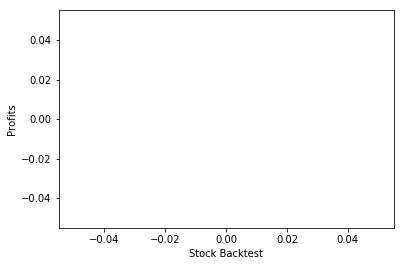

In [14]:
length = len(profits)
timesteps = [i for i in range(length)]
plt.plot(timesteps, profits)
plt.xlabel('Stock Backtest')
plt.ylabel('Profits')

In [15]:
for key in info:
    print (key)
    print(info[key]["Elos"])
    print(info[key]["NumWins"])
    print(info[key]["NumLoss"])

NameError: name 'info' is not defined

In [16]:
#time to play around with elos
def newElos(myElo, opsElo, matchWon):
    newElo = 0
    deltaElo = myElo-opsElo
    if matchWon:
        differenceMultiplier = (-deltaElo+150)/150 if deltaElo < 0 else 1/((deltaElo+150)/150)
        newElo = myElo + 8*differenceMultiplier
        newElo = min(myElo+150,newElo)
    else:
        differenceMultiplier = (deltaElo+150)/150 if deltaElo > 0 else 1/((-deltaElo+150)/150)
        newElo = myElo - 8*differenceMultiplier
        newElo = max(myElo-150,newElo)
    #print(newElo)
    return newElo

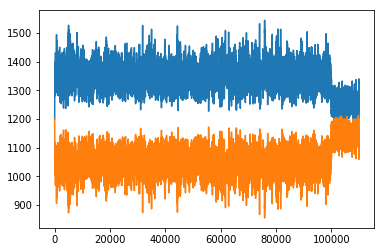

In [17]:
player1 = 1200
player2 = 1200
play1 = [1200]
play2 = [1200]
results = [[1200,1200]]
for i in range(100000):
    play1Wins = True
    newNum = random.randint(1,10)
    if newNum == 1:
        play1Wins = False
    copy = player1
    player1 = newElos(player1,player2,play1Wins)
    player2 = newElos(player2,copy,not play1Wins)
    results.append([player1,player2])
    play1.append(player1)
    play2.append(player2)

for i in range(10000):
    play1Wins = True
    newNum = random.randint(1,4)
    if newNum == 1:
        play1Wins = False
    copy = player1
    player1 = newElos(player1,player2,play1Wins)
    player2 = newElos(player2,copy,not play1Wins)
    results.append([player1,player2])
    play1.append(player1)
    play2.append(player2)


#print(results)
#print(results[-1])
plt.plot(play1)
plt.plot(play2)
plt.show()

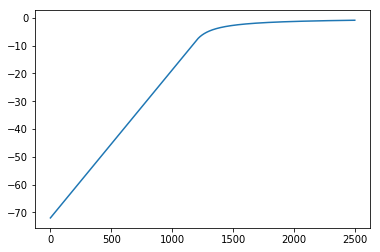

In [18]:
ratings = []
changeInRatings = []
currentRating = 1200
for i in range(2500):
    ratings.append(i)
    newplayer1 = newElos(1200,i,False)
    changeInRatings.append(newplayer1-1200)
    
plt.plot(ratings,changeInRatings)

In [19]:
import pandas as pd
import numpy as np

In [20]:
#clean the data
g = 0
primary = pd.read_csv("SP500Stocks/AAPL.csv")
primary_dates = primary["Date"].values.tolist()
filteredDataFolder = "./SP500Stocks/Filtered/"
for filename in os.listdir("./SP500Stocks"):
    if "csv" in filename:
        df = pd.read_csv("./SP500Stocks/"+filename)
        #print(df["Date"].values[0])
        #print(len(df["Date"].values))
        if df["Date"].values.tolist() != primary_dates:
            g+=1
            print(deletedFileName)
            deletedFileName = filteredDataFolder+filename
            #df.to_csv(deletedFileName, index=False)
            #os.remove("./SP500Stocks/"+filename)
        #if df[]
        #filenames.append(filename)
print(g)

0


In [21]:
aapl = pd.read_csv("SP500Stocks/AAPL.csv")
aapl.head()
aapl.shape

(2413, 7)

In [6]:
def returns(directory, stock):
    df = pd.read_csv(os.path.join(directory, stock), usecols=["Date", "Adj Close"], parse_dates=False)
    df["daily_returns"] = df["Adj Close"].diff().astype("float64")
    df["daily_returns"] = 100 * df["daily_returns"] / df["Adj Close"].shift(1)
    df["5_day_returns"] = df["daily_returns"].rolling(5).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1), raw=False).astype("float64")
    df["Date"] = df["Date"].astype(str)
    df.dropna(inplace=True)
    df.drop(columns="Adj Close", inplace=True)
    df.columns = [stock[:-4] + "_" + col if col != "Date" else col for col in df.columns]
    return df

In [23]:
#merge all stocks together
directory = "SP500Stocks"
files = os.listdir(directory)
master = returns(directory,files[0])

for filename in files[1:]:
    if "csv" in filename:
        master = master.merge(returns(directory,filename), on="Date")
master.head()

,Date,CSCO_daily_returns,CSCO_5_day_returns,UAL_daily_returns,UAL_5_day_returns,TROW_daily_returns,TROW_5_day_returns,ISRG_daily_returns,ISRG_5_day_returns,PRGO_daily_returns,...,LRCX_daily_returns,LRCX_5_day_returns,NWL_daily_returns,NWL_5_day_returns,UAA_daily_returns,UAA_5_day_returns,BLK_daily_returns,BLK_5_day_returns,PPL_daily_returns,PPL_5_day_returns
0,2009-09-18,0.042771,1.342568,-0.930233,11.227154,0.911103,5.895731,1.320038,3.128122,-1.024511,...,3.086259,-1.985040,3.272250,4.434149,1.963486,12.248768,2.351425,2.686235,0.196202,5.728087
1,2009-09-21,0.982905,3.685827,10.328638,11.506524,-1.633727,2.234123,-0.560664,1.594825,1.882043,...,-0.088038,-3.322882,-0.760437,3.026331,3.614865,8.990760,-1.385227,1.535545,-0.228471,3.979568
2,2009-09-22,-0.931012,1.871213,-3.723404,2.957907,3.103170,5.548107,-0.008114,1.248607,0.215547,...,1.997629,1.077154,1.021707,4.698890,-2.999674,4.679803,1.899030,3.752476,0.850537,3.525896
3,2009-09-23,-2.605789,-2.397286,-3.535912,-3.960396,-0.042405,2.365992,-0.681510,-0.926678,-1.075302,...,-0.835252,0.613682,0.189650,1.602571,-4.268908,-1.759227,1.359271,1.966560,-0.778482,-0.130576
4,2009-09-24,-0.657809,-3.163703,1.145475,2.674419,-3.880406,-1.670254,-1.155909,-1.099352,-0.683244,...,-1.306981,2.813961,-2.839156,0.785329,-1.228933,-3.100241,-2.265106,1.887063,-0.163442,-0.130801


In [1]:
print(len(files))

NameError: name 'files' is not defined

In [25]:
master["Date"]

0       2009-09-18
1       2009-09-21
2       2009-09-22
3       2009-09-23
4       2009-09-24
5       2009-09-25
6       2009-09-28
7       2009-09-29
8       2009-09-30
9       2009-10-01
10      2009-10-02
11      2009-10-05
12      2009-10-06
13      2009-10-07
14      2009-10-08
15      2009-10-09
16      2009-10-12
17      2009-10-13
18      2009-10-14
19      2009-10-15
20      2009-10-16
21      2009-10-19
22      2009-10-20
23      2009-10-21
24      2009-10-22
25      2009-10-23
26      2009-10-26
27      2009-10-27
28      2009-10-28
29      2009-10-29
           ...    
1150    2019-03-04
1151    2019-03-05
1152    2019-03-06
1153    2019-03-07
1154    2019-03-08
1155    2019-03-11
1156    2019-03-12
1157    2019-03-13
1158    2019-03-14
1159    2019-03-15
1160    2019-03-18
1161    2019-03-19
1162    2019-03-20
1163    2019-03-21
1164    2019-03-22
1165    2019-03-25
1166    2019-03-26
1167    2019-03-27
1168    2019-03-28
1169    2019-03-29
1170    2019-04-01
1171    2019

In [58]:
#returns a dictionary each stock name is the key and value is 2d array row is 1 day, col is 5 day
def createPlayers(stocks, bins):
    stocks_lower = [stock.lower() for stock in stocks]
    consolidated = {}
    if len(stocks) == 0:
        for filename in os.listdir("./SP500Stocks"):
            if "csv" in filename:
                consolidated[filename[:-4]] = [[0]*bins]*bins
    else:
        for filename in os.listdir("./SP500Stocks"):
            if "csv" in filename and filename[:-4].lower() in stocks_lower:
                consolidated[filename[:-4]] = [[0]*bins]*bins
    return consolidated
#createPlayers([],2)

{'CSCO': [[0, 0], [0, 0]],
 'UAL': [[0, 0], [0, 0]],
 'TROW': [[0, 0], [0, 0]],
 'ISRG': [[0, 0], [0, 0]],
 'PRGO': [[0, 0], [0, 0]],
 'TPR': [[0, 0], [0, 0]],
 'DVN': [[0, 0], [0, 0]],
 'CE': [[0, 0], [0, 0]],
 'MRO': [[0, 0], [0, 0]],
 'BA': [[0, 0], [0, 0]],
 'VRTX': [[0, 0], [0, 0]],
 'GILD': [[0, 0], [0, 0]],
 'EQIX': [[0, 0], [0, 0]],
 'TIF': [[0, 0], [0, 0]],
 'MDT': [[0, 0], [0, 0]],
 'V': [[0, 0], [0, 0]],
 'A': [[0, 0], [0, 0]],
 'FOX': [[0, 0], [0, 0]],
 'MO': [[0, 0], [0, 0]],
 'WCG': [[0, 0], [0, 0]],
 'SWKS': [[0, 0], [0, 0]],
 'MCHP': [[0, 0], [0, 0]],
 'CDNS': [[0, 0], [0, 0]],
 'WLTW': [[0, 0], [0, 0]],
 'MSCI': [[0, 0], [0, 0]],
 'EIX': [[0, 0], [0, 0]],
 'BBY': [[0, 0], [0, 0]],
 'WBA': [[0, 0], [0, 0]],
 'AJG': [[0, 0], [0, 0]],
 'DTE': [[0, 0], [0, 0]],
 'C': [[0, 0], [0, 0]],
 'T': [[0, 0], [0, 0]],
 'CF': [[0, 0], [0, 0]],
 'DISH': [[0, 0], [0, 0]],
 'MGM': [[0, 0], [0, 0]],
 'HUM': [[0, 0], [0, 0]],
 'WU': [[0, 0], [0, 0]],
 'APH': [[0, 0], [0, 0]],
 'SYY': [[0,

In [30]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_unweighted_bet_strat(master,stocks, bins, flexibility):
    players = createPlayers(stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    day_profits = []
    for i in range(master.shape[0]-1):
        for stock_1 in trading_stocks:
            print(stock_1)
            print(master.iloc[i][stock_1+"_daily_returns"])
            print(master.iloc[i][stock_1+"_5_day_returns"])
            numCollisions = 0
            for stock_2 in trading_stocks:
                if stock_1 != stock_2 and get2DBin((master.iloc[i][stock_1+"_daily_returns"],
                             master.iloc[i][stock_1+"_5_day_returns"]), bins) == get2DBin((master.iloc[i][stock_2+"_daily_returns"],
                             master.iloc[i][stock_2+"_5_day_returns"]), bins):
                    print(stock_1)
                    print(stock_2)
                
                #continue
                #print(stock_1)
                #print(master.iloc[i][stock_1+"_daily_returns"])
                #print(master.iloc[i][stock_1+"_5_day_returns"])
        return
        print (i)
binary_unweighted_bet_strat(master, [],5,.01)      

NameError: name 'master' is not defined

In [1]:
a = master.values
a_new = []
for row in a:
    row_new = []
    print(row[0])
    exit()
    for index in range(1,len(row),2):
        row_new.append((row[index],row[index+1]))
    a_new.append(row)
a_new

NameError: name 'master' is not defined

## Random Walk 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
length = 2400
index = []
for i in range(length):
    index.append(i)

In [11]:
for i in range(5):
    stock = np.zeros(length)
    stock[0] = 30
    for j in range(1,length):
        stock[j] = stock[j-1]*(1 + np.random.normal()/100)
    df_dict = {}
    df_dict["Date"] = index
    df_dict["Adj Close"] = stock
    df = pd.DataFrame(df_dict)
    df.to_csv(f"random_walks/STK{i}.csv")

In [12]:
import os
stk1 = returns("random_walks", "STK1.csv")
stk1.head()

,Date,STK1_daily_returns,STK1_5_day_returns
5,5,0.272293,3.925879
6,6,0.165075,2.532487
7,7,0.159674,1.247780
8,8,-0.631735,0.723605
9,9,-0.440842,-0.478001
